In [14]:
import os
import numpy as np
from PIL import Image
from pathlib import Path
from torchvision.transforms.v2 import Resize
from torchvision.transforms.v2.functional import to_pil_image

from anomalib.data.image.folder import Folder, FolderDataset
from anomalib import TaskType

In [15]:
def draw_pic(inferencer, png_files, input_path, outpath):
    from anomalib.data.utils import read_image
    import time
    import matplotlib.pyplot as plt


    for file_name in png_files:
            
        image = read_image(path=os.path.join(input_path, file_name))

        # 记录开始时间
        start_time = time.time()
        predictions = inferencer.predict(image=image)
        # 记录结束时间
        end_time = time.time()

        # 计算耗时
        elapsed_time = end_time - start_time
        print(f"Prediction took {elapsed_time:.4f} seconds.")
        print(predictions.pred_score, predictions.pred_label)
        # 创建一个新的图形窗口
        fig, axs = plt.subplots(1, 3, figsize=(18, 8))  # 创建一个1行3列的子图网格

        # 原始图像
        axs[0].imshow(image)
        axs[0].set_title('Original Image')
        axs[0].axis('off')  # 关闭坐标轴

        # 热图
        axs[1].imshow(predictions.heat_map, cmap='hot', interpolation='nearest')
        axs[1].set_title('Heat Map')
        axs[1].axis('off')  # 关闭坐标轴

        # 预测掩模
        axs[2].imshow(predictions.pred_mask, cmap='gray', interpolation='nearest')
        axs[2].set_title('Predicted Mask')
        axs[2].axis('off')  # 关闭坐标轴


        # 添加文本信息到图形的上方中间位置
        fig_text_x = 0.1  # x坐标在图形宽度的中心位置
        fig_text_y = 0.95  # y坐标稍微靠近图形的顶部，避免与子图重叠
        fig.text(fig_text_x, fig_text_y,
                f'Prediction Time: {elapsed_time:.4f} s\n'
                f'Predicted Class: {predictions.pred_label}\n'
                # f'Score: {predictions.pred_score:.4f}\n'
                f'Threshold: {predictions.pred_score:.4f}' if hasattr(predictions, 'pred_score') else '',
                ha='left', va='center', fontsize=12,
                bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.5))  

        # 显示整个图形
        plt.tight_layout()  # 调整子图间的间距
        #plt.show()
        plt.savefig(os.path.join(outpath, file_name))
        plt.close()
        
    print("Done")

## 参数配置

In [16]:
configs = {
    "dataset_root": r"F:\Projects\anomalib\notebooks\datasets\3-5",
    "outputs_path": r"F:\Projects\anomalib\notebooks\datasets\3-5\outputs",
    "model_name": "Fastflow",
}

dataset_root = configs["dataset_root"]
print("dataset_root: {}".format(dataset_root))

normal_folder_path = os.path.join(configs["dataset_root"], "normal")
abnormal_folder_path = os.path.join(configs["dataset_root"], "abnormal")

normal_ouput_path = os.path.join(configs["outputs_path"], configs["model_name"] , "normal_outputs")
abnormal_output_path = os.path.join(configs["outputs_path"], configs["model_name"] , "abnormal_outputs")

dataset_root: F:\Projects\anomalib\notebooks\datasets\3-5


## Custom 数据集配置

In [17]:
folder_datamodule = Folder(
    name="3-5",
    root=dataset_root,
    normal_dir="normal",
    abnormal_dir="abnormal",
    task=TaskType.CLASSIFICATION,
    image_size=(256, 256),
)

folder_datamodule.setup()            #! 进行数据集分割

INFO:anomalib.data.base.datamodule:No normal test images found. Sampling from training set using a split ratio of 0.20


==> 检查训练集、验证集、测试集的数据量

In [18]:
# Train images
i, data = next(enumerate(folder_datamodule.train_dataloader()))
print(data.keys(), data["image"].shape)

dict_keys(['image_path', 'label', 'image']) torch.Size([16, 3, 256, 256])


In [19]:
# Train images
i, data = next(enumerate(folder_datamodule.val_dataloader()))
print(data.keys(), data["image"].shape)

dict_keys(['image_path', 'label', 'image']) torch.Size([17, 3, 256, 256])


In [20]:
# Test images
i, data = next(enumerate(folder_datamodule.test_dataloader()))
print(data.keys(), data["image"].shape)

dict_keys(['image_path', 'label', 'image']) torch.Size([18, 3, 256, 256])


==> 查看图像内容

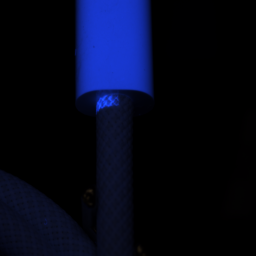

In [21]:
img = to_pil_image(data["image"][0].clone())
# msk = to_pil_image(data["mask"][0]).convert("RGB")
Image.fromarray((np.array(img)))

## 模型选择和优化器配置

In [ ]:
from anomalib.engine import Engine
from anomalib.models import Padim, Patchcore, Stfpm, Fastflow

if configs["model_name"] == "Patchcore":
    model = Patchcore()
    engine = Engine(task=TaskType.CLASSIFICATION)
    engine.train(datamodule=folder_datamodule, model=model)
elif configs["model_name"] == "Fastflow":
    model = Fastflow()
    engine = Engine(
    pixel_metrics="AUROC",
    accelerator="auto",  # \<"cpu", "gpu", "tpu", "ipu", "hpu", "auto">,
    logger=False,
    task=TaskType.CLASSIFICATION)
    engine.train(datamodule=folder_datamodule, model=model)
else:
    model = Patchcore()
    engine = Engine(task=TaskType.CLASSIFICATION)
    engine.train(datamodule=folder_datamodule, model=model)
    

print(engine.trainer.default_root_dir)

INFO:anomalib.models.components.base.anomaly_module:Initializing Fastflow model.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
e:\Appsetup\Anaconda\envs\anoma\lib\site-packages\lightning\pytorch\loops\utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
INFO:anomalib.data.base.datamodule:No normal test images found. Sampling from training set using a split ratio of 0.20
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type     

Training: |          | 0/? [00:00<?, ?it/s]

e:\Appsetup\Anaconda\envs\anoma\lib\site-packages\lightning\pytorch\core\module.py:516: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |          | 0/? [00:00<?, ?it/s]

## 模型导出

In [ ]:
from anomalib.deploy import ExportType
engine.export( model=model, export_type=ExportType.OPENVINO)
print(f"Model save to {engine.trainer.default_root_dir}).") 

F:\Projects\anomalib\src\anomalib\data\transforms\center_crop.py:57: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if image.numel() == 0:
F:\Projects\anomalib\src\anomalib\data\transforms\center_crop.py:61: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if crop_height > image_height or crop_width > image_width:
F:\Projects\anomalib\src\anomalib\data\transforms\center_crop.py:41: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant varia

Model save to F:\Projects\anomalib\notebooks\100_datamodules\results\Patchcore\3-5\latest).


In [ ]:
model_output_path=Path(engine.trainer.default_root_dir)
openvino_model_path = model_output_path / "weights" / "openvino" / "model.bin"
metadata_path = model_output_path / "weights" / "openvino" / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

True True


## 模型测试

In [ ]:
from anomalib.deploy import OpenVINOInferencer
inferencer = OpenVINOInferencer(
    path=openvino_model_path,    # Path to the OpenVINO IR model.
    metadata=metadata_path,      # Path to the metadata file.
    device="AUTO",               # We would like to run it on an Intel CPU.
)

In [ ]:
# 待测试图像
normal_png_files = [f for f in os.listdir(normal_folder_path) if f.endswith('.png')]
abnormal_png_files = [f for f in os.listdir(abnormal_folder_path) if f.endswith('.png')]
print(normal_png_files)
print(abnormal_png_files)


# 输出路径确认
if os.path.exists(normal_ouput_path): os.removedirs(normal_ouput_path)
if os.path.exists(abnormal_output_path): os.removedirs(abnormal_output_path)
os.makedirs(normal_ouput_path)
os.makedirs(abnormal_output_path)


# 模型测试
draw_pic(inferencer, normal_png_files, normal_folder_path, normal_ouput_path)
draw_pic(inferencer, abnormal_png_files, abnormal_folder_path, abnormal_output_path)

['11__DA2951215.png', '11__DA2951225.png', '15__DA2951175.png', '17__DA2951215.png', '19__DA1479053.png', '19__DA2951175.png', '19__DA2951215.png', '1__DA2951175.png', '1__DA2951215.png', '3__DA2951175.png', '3__DA2951215.png', '3__DA2951225.png', '5__DA1479053.png', '5__DA2951175.png', '5__DA2951215.png', '7__DA1479053.png', '7__DA2951215.png', '7__DA2951225.png', '9__DA1479053.png', '9__DA2951175.png']
['11__DA1479053.png', '11__DA2951175.png', '13__DA1479053 (2).png', '13__DA1479053.png', '13__DA2951175.png', '13__DA2951215.png', '13__DA2951225.png', '15__DA1479053 (2).png', '15__DA1479053.png', '15__DA2951215 - 副本.png', '15__DA2951215.png', '15__DA2951225 - 副本.png', '15__DA2951225.png', '17__DA1479053 (2) - 副本.png', '17__DA1479053 (2).png', '17__DA1479053 - 副本.png', '17__DA1479053.png', '17__DA2951175 - 副本.png', '17__DA2951175.png', '17__DA2951225 - 副本.png', '17__DA2951225.png', '19__DA2951225 - 副本.png', '19__DA2951225.png', '1__DA1479053 (2).png', '1__DA1479053.png', '1__DA2951225

C:\Users\Lixutong\AppData\Local\Temp\ipykernel_19820\2638120288.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 3, figsize=(18, 8))  # 创建一个1行3列的子图网格


Prediction took 0.2843 seconds.
0.9278331125902622 LabelName.ABNORMAL
Prediction took 0.2625 seconds.
1.0 LabelName.ABNORMAL
Prediction took 0.2861 seconds.
1.0 LabelName.ABNORMAL
Prediction took 0.2674 seconds.
1.0 LabelName.ABNORMAL
Prediction took 0.2803 seconds.
0.4818724283902888 LabelName.NORMAL
Prediction took 0.2757 seconds.
1.0 LabelName.ABNORMAL
Prediction took 0.2704 seconds.
0.9471380119568379 LabelName.ABNORMAL
Prediction took 0.2817 seconds.
0.9471380119568379 LabelName.ABNORMAL
Prediction took 0.2897 seconds.
0.5777762088860147 LabelName.ABNORMAL
Prediction took 0.2771 seconds.
0.5777762088860147 LabelName.ABNORMAL
Prediction took 0.2713 seconds.
1.0 LabelName.ABNORMAL
Prediction took 0.2853 seconds.
1.0 LabelName.ABNORMAL
Prediction took 0.2788 seconds.
1.0 LabelName.ABNORMAL
Prediction took 0.2787 seconds.
1.0 LabelName.ABNORMAL
Prediction took 0.2848 seconds.
1.0 LabelName.ABNORMAL
Prediction took 0.2893 seconds.
1.0 LabelName.ABNORMAL
Prediction took 0.3044 seconds.


`Folder` data module offers much more flexibility cater all different sorts of needs. Please refer to the documentation for more details.


We can add some transforms that will be applied to the images using torchvision. Let's add a transform that resizes the 
input image to 256x256 pixels.

In [ ]:
image_size = (256, 256)
transform = Resize(image_size, antialias=True)

#### Classification Task


In [ ]:
folder_dataset_classification_train = FolderDataset(
    name="3-5",
    normal_dir=dataset_root / "normal",
    abnormal_dir=dataset_root / "abnormal",
    split="train",
    transform=transform,
    task=TaskType.CLASSIFICATION,
)
folder_dataset_classification_train.samples.head()

,image_path,label,label_index,mask_path,split
0,F:\Projects\anomalib\notebooks\datasets\3-5\no...,DirType.NORMAL,0,,Split.TRAIN
1,F:\Projects\anomalib\notebooks\datasets\3-5\no...,DirType.NORMAL,0,,Split.TRAIN
2,F:\Projects\anomalib\notebooks\datasets\3-5\no...,DirType.NORMAL,0,,Split.TRAIN
3,F:\Projects\anomalib\notebooks\datasets\3-5\no...,DirType.NORMAL,0,,Split.TRAIN
4,F:\Projects\anomalib\notebooks\datasets\3-5\no...,DirType.NORMAL,0,,Split.TRAIN


Let's look at the first sample in the dataset.


dict_keys(['image_path', 'label', 'image']) torch.Size([3, 256, 256])


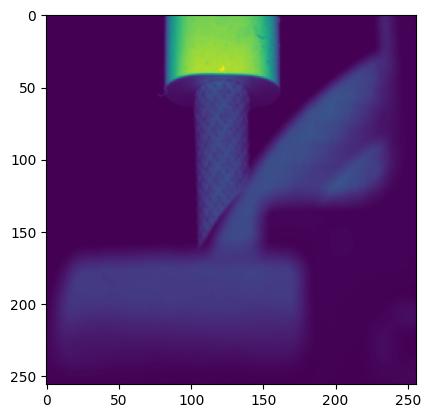

In [ ]:
data = folder_dataset_classification_train[0]
print(data.keys(), data["image"].shape)
import matplotlib.pyplot as plt
plt.imshow(data["image"][2])   # RGB

As can be seen above, when we choose `classification` task and `train` split, the dataset only returns `image`. This is mainly because training only requires normal images and no labels. Now let's try `test` split for the `classification` task


In [ ]:
# Folder Classification Test Set
folder_dataset_classification_test = FolderDataset(
    name="3-5",
    normal_dir=dataset_root / "normal",
    abnormal_dir=dataset_root / "abnormal",
    split="test",
    transform=transform,
    task=TaskType.CLASSIFICATION,
)
folder_dataset_classification_test.samples.head()

,image_path,label,label_index,mask_path,split
0,F:\Projects\anomalib\notebooks\datasets\3-5\ab...,DirType.ABNORMAL,1,,Split.TEST
1,F:\Projects\anomalib\notebooks\datasets\3-5\ab...,DirType.ABNORMAL,1,,Split.TEST
2,F:\Projects\anomalib\notebooks\datasets\3-5\ab...,DirType.ABNORMAL,1,,Split.TEST
3,F:\Projects\anomalib\notebooks\datasets\3-5\ab...,DirType.ABNORMAL,1,,Split.TEST
4,F:\Projects\anomalib\notebooks\datasets\3-5\ab...,DirType.ABNORMAL,1,,Split.TEST


In [ ]:
data = folder_dataset_classification_test[0]
print(data.keys(), data["image"].shape, data["image_path"], data["label"])

dict_keys(['image_path', 'label', 'image']) torch.Size([3, 256, 256]) F:\Projects\anomalib\notebooks\datasets\3-5\abnormal\11__DA1479053.png 1
